In [44]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import os, re
import matplotlib.pyplot as plt


In [45]:
percorso = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data")
files = [f for f in os.listdir(percorso) if os.path.isfile(os.path.join(percorso, f))]
print(files)

['SIRSensor_TOS01000025_rainDelta15_desc.csv', 'SIRSensor_TOS01000025_humidity_desc.csv', 'SIRSensor_TOS01000056_humidity_df.xlsx', 'tusc_weather_sensor_ow_3180733_pressure_df.csv', 'tusc_weather_sensor_ow_3170317_visibility_desc.csv', 'SIRSensor_TOS01001273_rainDelta15_df.csv', 'ARPAT_QA_PO-ROMA_Benzene_df.xlsx', 'tusc_weather_sensor_ow_3180733_airTemperature_desc.xlsx', 'TOS_with_embeddings.xlsx', 'tusc_weather_sensor_ow_3170317_windDirection_desc.csv', 'METRO854_vehicleFlow_desc.xlsx', 'tusc_weather_sensor_ow_3178402_windSpeed_desc.xlsx', 'METRO966_averageSpeed_desc.xlsx', 'METRO521_averageSpeed_df.xlsx', 'SIRSensor_TOS01000056_rainDelta15_df.xlsx', 'tusc_weather_sensor_ow_3178402_windSpeed_desc.csv', 'SIRSensor_TOS01005131_rainDelta15_desc.xlsx', 'ARPAT_QA_SI-POGGIBONSI_SV_Benzene_df.xlsx', 'SIRSensor_TOS11000054_temperature_df.xlsx', 'METRO698_concentration_df.xlsx', 'SIRSensor_TOS01005131_rainDelta15_df.xlsx', 'tusc_weather_sensor_ow_3170317_pressure_desc.xlsx', 'METRO698_congest

In [46]:
def smart_interpolation(df_list):
    for i, df in enumerate(df_list):
        print(f"Processing dataset {i+1}...")
        
        for column in df.columns:
            missing_count = df[column].isna().sum()
            if missing_count > 0:
                print(f"  - Column '{column}': {missing_count} missing values")
                
                # Colonne numeriche
                if pd.api.types.is_numeric_dtype(df[column]):
                    # Se pochi missing values, interpolazione
                    if missing_count / len(df) < 0.1:  # meno del 10%
                        df[column].interpolate(method='linear', inplace=True)
                    else:
                        # Se molti missing, usa la media
                        df[column].fillna(df[column].mean(), inplace=True)
                
                # Colonne stringa/categoriche
                elif pd.api.types.is_string_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
                    # Usa la moda (valore più frequente)
                    mode_values = df[column].mode()
                    if not mode_values.empty:
                        df[column].fillna(mode_values[0], inplace=True)
                    else:
                        df[column].fillna('Unknown', inplace=True)
                
                # Colonne datetime
                elif pd.api.types.is_datetime64_any_dtype(df[column]):
                    df[column].interpolate(method='linear', inplace=True)
        
        print(f"Completed dataset {i+1}")

In [47]:
to_keep = ['type_of_TTT', 'min', 'var', 'median', 'interval_end', 
            'is_festive', 'mean', 'max', 'interval_start', 'linear_trend',
            'is_weekend', 'EMBEDDING','month', 'avg_variation', 
            'TTT','day'
            ]

selezionati = [p for p in files if re.search(r'TOS_with+.+(?<!df)\.xlsx', p)]
print (selezionati)
dati = [pd.read_excel(percorso+'/'+p, usecols=to_keep) for p in selezionati]
smart_interpolation(dati)
dtset_completo = pd.concat(dati, ignore_index=True)
print(dtset_completo.shape)

['TOS_with_embeddings.xlsx']
Processing dataset 1...
  - Column 'linear_trend': 480 missing values
Completed dataset 1
(5320, 16)


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_24566/128093249.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].interpolate(method='linear', inplace=True)


In [48]:
import ast


'''# to_keep contiene i nomi delle colonne che vuoi mantenere (puoi scriverli in minuscolo)
to_keep_lower = [c.lower() for c in to_keep]

# mappa le colonne del DataFrame in minuscolo
col_map = {col.lower(): col for col in dtset_completo.columns}

# seleziona solo le colonne presenti nel DataFrame, case-insensitive
cols_to_select = [col_map[c] for c in to_keep_lower if c in col_map]

# applica la selezione
dtset_completo = dtset_completo[cols_to_select]'''

mask = ~dtset_completo['TTT'].str.contains("nan", na=True)
dtset_completo = dtset_completo[mask]

dtset_completo['TTT'] = dtset_completo['TTT'].apply(ast.literal_eval)

In [49]:
# Filtra le righe dove la colonna TTT ha lunghezza 24, ed elimina tutte le colonne le cui osservazioni sono indipendenti dal giorno
dtset_filtrato = dtset_completo[dtset_completo["TTT"].apply(lambda x: len(x) == 24)].sample(frac=1).reset_index(drop=True)
dtset_filtrato = dtset_filtrato[dtset_filtrato["type_of_TTT"] == "daily"]
len(dtset_filtrato)

4500

In [50]:
import numpy as np


def is_useful_series(series, zero_ratio_thr=0.75, var_thr=5e-1, unique_thr=3):
    arr = np.array(series, dtype=float)
    
    # Varianza
    if np.var(arr) <= var_thr:
        return False
    
    # Percentuale di zeri
    zero_ratio = (arr == 0).mean()
    if zero_ratio >= zero_ratio_thr:
        return False
    
    # Numero valori distinti
    if len(np.unique(arr)) <= unique_thr:
        return False
    
    return True

# Applica filtro
mask_useful = dtset_filtrato["TTT"].apply(is_useful_series)
df_useful = dtset_filtrato[mask_useful]

In [51]:
def spezza_serie_in_colonne(df, colonna_stringa, prefix='col_'):
# Verifica che la colonna esista
    if colonna_stringa not in df.columns:
        raise ValueError(f"La colonna '{colonna_stringa}' non esiste nel DataFrame")
    
    # Crea una copia del DataFrame
    result_df = df.copy()
    
    # Rimuove la colonna originale
    colonna_originale = result_df.pop(colonna_stringa)
    
    # Lista per raccogliere tutti gli array convertiti
    arrays_convertiti = []
    
    # Converte ogni stringa in array numerico
    for stringa in colonna_originale:
        # Gestione di valori NaN o stringhe vuote
        if pd.isna(stringa) or stringa == '':
            arrays_convertiti.append([])
            continue
            
        # Rimuove le parentesi quadre se presenti
        stringa_pulita = str(stringa).strip('[]')
        
        # Divide per spazi multipli e filtra stringhe vuote
        valori = [x for x in stringa_pulita.split() if x]
        
        # Converte in float
        try:
            array_numerico = [float(x) for x in valori]
            arrays_convertiti.append(array_numerico)
        except ValueError as e:
            print(f"Errore nella conversione di '{stringa}': {e}")
            arrays_convertiti.append([])
    
    # Trova la lunghezza massima per determinare il numero di colonne
    lunghezze = [len(arr) for arr in arrays_convertiti]
    
    if not lunghezze:
        raise ValueError("Nessun dato valido trovato nella colonna")
    
    lunghezza_max = max(lunghezze)
    lunghezza_min = min(lunghezze)
    
    # Verifica che tutti gli array abbiano la stessa lunghezza
    if lunghezza_max != lunghezza_min:
        print(f"Attenzione: array di lunghezze diverse (min: {lunghezza_min}, max: {lunghezza_max})")
        print("I valori mancanti verranno riempiti con NaN")
        
        # Riempie con NaN gli array più corti
        arrays_completi = []
        for arr in arrays_convertiti:
            if len(arr) < lunghezza_max:
                arr_completo = arr + [np.nan] * (lunghezza_max - len(arr))
                arrays_completi.append(arr_completo)
            else:
                arrays_completi.append(arr)
    else:
        arrays_completi = arrays_convertiti
    
    # Crea il DataFrame con le nuove colonne
    nuove_colonne = pd.DataFrame(
        arrays_completi,
        index=result_df.index,
        columns=[f"{prefix}{i}" for i in range(lunghezza_max)]
    )
    
    # Combina con il DataFrame originale
    result_df = pd.concat([result_df, nuove_colonne], axis=1)
    
    return result_df

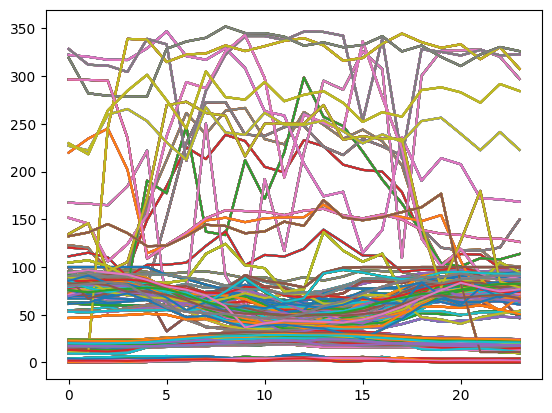

In [52]:
for ttt in df_useful.TTT:
    plt.plot(ttt)

In [53]:
def summary_df(df):
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'n_missing': df.isna().sum(),
        '%_missing': (df.isna().mean() * 100).round(2),
        'n_unique': df.nunique(),
        'top_value': df.mode().iloc[0],  # moda
        'top_freq': [df[col].value_counts(dropna=True).iloc[0] if not df[col].value_counts(dropna=True).empty else None for col in df.columns],
        'min': [df[col].min() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],
        'max': [df[col].max() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],
        'mean': [df[col].mean() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],
        'std': [df[col].std() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],
    })
    return summary


In [54]:
#Nella precedente sono state eliminate le colonne con Nan, tuttavia alcuni dataset dei sensori METRO hanno dei Nan in city e surface dunque vengono rimossi nel prcedente box

categorical = [
    'is_weekend',
    'is_festive'
    ]

#consiglio, per serie cicliche usare funzioni periodiche tipo seno coseno 
df_encoded = pd.get_dummies(df_useful
                            , columns=categorical)


In [55]:
#codifica ciclica delle features e individuazione del'ora del giorno e della settimana 

def encode_time_features(df, start_col="interval_start", end_col="interval_end"):
    df = df.copy()
    
    # Step 1: Ensure datetime columns are in the correct format first
    df[start_col] = pd.to_datetime(df[start_col], utc=True, format="mixed")
    df[end_col] = pd.to_datetime(df[end_col], utc=True, format="mixed")

    # Step 2: Extract 'month' and 'day' after conversion
    df['month'] = df[start_col].dt.month
    df['day'] = df[start_col].dt.dayofweek # Note: dayofweek is typically used for cyclical weekly patterns
    
    # Step 3: Now you can create the cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['month']/len(df['month'].unique()))
    df['month_cos'] = np.cos(2 * np.pi * df['month']/len(df['month'].unique()))
    df['day_sin'] = np.sin(2 * np.pi * df['day']/len(df['day'].unique()))
    df['day_cos'] = np.cos(2 * np.pi * df['day']/len(df['day'].unique()))


    # Ora del giorno (0-23) → ciclo giornaliero
    df["hour"] = df[start_col].dt.hour
    angle_day_start = 2 * np.pi * df["hour"] / 24
    df["start_time_sin"] = np.sin(angle_day_start)
    df["start_time_cos"] = np.cos(angle_day_start)

    df["hour_end"] = df[end_col].dt.hour
    angle_day_end = 2 * np.pi * df["hour_end"] / 24
    df["end_time_sin"] = np.sin(angle_day_end)
    df["end_time_cos"] = np.cos(angle_day_end)

    # Durata in minuti
    df["duration_minutes"] = (df[end_col] - df[start_col]).dt.total_seconds() / 60

    # Giorno della settimana (0=Mon..6=Sun) → ciclo settimanale
    dayofweek = df[start_col].dt.dayofweek
    angle_week = 2 * np.pi * dayofweek / 7
    df["dow_sin"] = np.sin(angle_week)
    df["dow_cos"] = np.cos(angle_week)

    # Giorno dell’anno (1-365) → ciclo annuale
    dayofyear = df[start_col].dt.dayofyear
    angle_year = 2 * np.pi * dayofyear / 365
    df["doy_sin"] = np.sin(angle_year)
    df["doy_cos"] = np.cos(angle_year)

    # Rimuovo colonne temporali e variabili ausiliarie
    df = df.drop(columns=[start_col, end_col, "hour", "hour_end", "day", "month"])
    return df

df_final = encode_time_features(df_encoded)
df_final.drop(columns=['type_of_TTT'], inplace=True)
df_final = spezza_serie_in_colonne(df_final, 'EMBEDDING', prefix='emb_')


In [56]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

def series_to_2d_array(series, output_dim=24):
    arr = np.stack(series.apply(lambda x: np.array(x, dtype=np.float32)))
    if arr.shape[1] != output_dim:
        raise ValueError(f"Ogni elemento deve avere {output_dim} valori, trovato {arr.shape[1]}")
    return arr

 # Separazione delle feature e del target
X = df_final.drop(columns=['TTT'])
y = df_final['TTT']

X_np = X.to_numpy().astype(np.float32)
y_np = series_to_2d_array(y, output_dim=24)

# Calcolo deviazione standard per ogni serie
std_scores = np.std(y_np, axis=1)

std_scores_log = np.log1p(std_scores)  # log(1+x) per evitare problemi con valori vicini a 0

std_scores_normalized = (std_scores_log - np.min(std_scores_log)) / (np.max(std_scores_log) - np.min(std_scores_log))

# Creo bin basati sui quantili
bins = np.array([0.0, 0.4, 0.8, 1.0])
std_bins = np.digitize(std_scores_normalized, bins)

# Primo split: train (80%) vs temp (20%)
# Passo anche std_bins per poter stratificare
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np,
    test_size=0.1,
    random_state=42,
    stratify=std_bins, 
    shuffle=True
)

print(f"Train size: {X_train.shape}, {y_train.shape}")
print(f"Test size: {X_test.shape}, {y_test.shape}")

# Debug prints
print(f"Final shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

# Scaler per input
scaler_X = RobustScaler()
X_train = scaler_X.fit_transform(X_train)
X_test  = scaler_X.transform(X_test)

# Scaler per output (se serve normalizzare anche y)
scaler_y = RobustScaler()
y_train = scaler_y.fit_transform(y_train)
y_test  = scaler_y.transform(y_test)

# Debug prints
#print("After normalization:")
#print(f"X_train: {X_train_np.shape}, mean={X_train_np.mean():.4f}, std={X_train_np.std():.4f}")
#print("Target range before normalization:", y_train.min(), y_train.max())
#print("Target range after normalization:", y_train_np.min(), y_train_np.max())
#print("Predictions range (normalized):", predictions_norm.min(), predictions_norm.max())

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Train size: (2367, 30), (2367, 24)
Test size: (263, 30), (263, 24)
Final shapes:
X_train: (2367, 30)
y_train: (2367, 24)
X_train: (2367, 30)
y_train: (2367, 24)
X_test: (263, 30)
y_test: (263, 24)


In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics # type: ignore
from tensorflow.keras.layers import Dropout # type: ignore
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [58]:
# Definizione modello DNN
def build_model(input_shape: tuple, output_shape: tuple):
    model = models.Sequential([
        layers.Dense(64, activation = "relu", input_shape=input_shape),
        Dropout(0.0),
        layers.Dense(output_shape, 'linear')
    ])
    model.compile(
    optimizer=optimizers.AdamW(learning_rate=0.0053, weight_decay=0.0005),
    loss= 'mae',
    metrics=['mae', 'mse'],
    )
    return model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # metrica da monitorare, es. val_loss o val_mae
    patience=30,             # numero di epoche senza miglioramento prima di fermare
    restore_best_weights=True,  # ripristina i pesi migliori trovati
    verbose = 1
)

In [59]:

model = build_model((X_test.shape[1],), y_test.shape[1])
history = model.fit(
    X_train, y_train,
    epochs=600,
    batch_size=128,
    callbacks = [early_stop],
    validation_split = 0.2,
    verbose=0
    )
y_pred = model.predict(X_test)

'''print("y_train min/max:", y_train_np.min(), y_train_np.max())
print("y_pred min/max (scaled):", y_pred.min(), y_pred.max())
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
print("y_pred_rescaled min/max:", y_pred_rescaled.min(), y_pred_rescaled.max())'''



/Users/lapotinacci/thesis/fd_train/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 355: early stopping
Restoring model weights from the end of the best epoch: 325.
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


'print("y_train min/max:", y_train_np.min(), y_train_np.max())\nprint("y_pred min/max (scaled):", y_pred.min(), y_pred.max())\ny_pred_rescaled = scaler_y.inverse_transform(y_pred)\nprint("y_pred_rescaled min/max:", y_pred_rescaled.min(), y_pred_rescaled.max())'

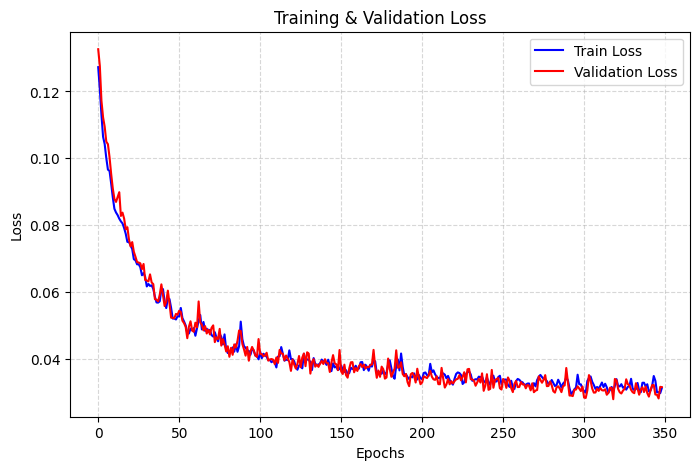

In [60]:
# Estrai losses da tutti i folds
train_losses = history.history['loss']
val_losses   = history.history['val_loss']

train_losses = train_losses[6:]
val_losses = val_losses[6:]

# Plot
plt.figure(figsize=(8,5))


# Training loss
plt.plot(train_losses, color='blue', label='Train Loss')


# Validation loss
plt.plot(val_losses, color='red', label='Validation Loss')


# Dettagli grafico
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()



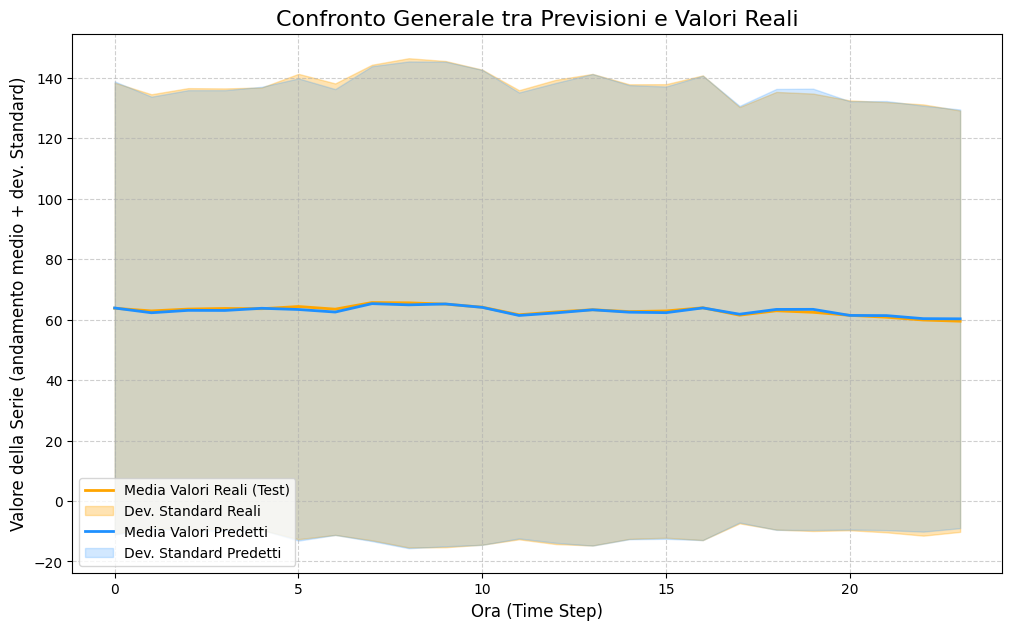

In [61]:
y_pred = scaler_y.inverse_transform(y_pred)
y_test_np = scaler_y.inverse_transform(y_test)

mean_pred = np.mean(y_pred, axis=0)
std_pred = np.std(y_pred, axis=0)

mean_test = np.mean(y_test_np, axis=0)
std_test = np.std(y_test_np, axis=0)

plt.figure(figsize=(12, 7))
time_axis = np.arange(len(mean_test))

plt.plot(time_axis, mean_test, 'orange', label='Media Valori Reali (Test)', linewidth=2)
plt.fill_between(time_axis,
                 mean_test - std_test,
                 mean_test + std_test,
                 color='orange', alpha=0.3, label='Dev. Standard Reali')

plt.plot(time_axis, mean_pred, 'dodgerblue', label='Media Valori Predetti', linewidth=2)
plt.fill_between(time_axis,
                 mean_pred - std_pred,
                 mean_pred + std_pred,
                 color='dodgerblue', alpha=0.2, label='Dev. Standard Predetti')

plt.title('Confronto Generale tra Previsioni e Valori Reali', fontsize=16)
plt.xlabel('Ora (Time Step)', fontsize=12)
plt.ylabel('Valore della Serie (andamento medio + dev. Standard)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [62]:
'''epsilon = 1e-8  # piccolo valore per evitare log(0) in scala log

for i in range(len(y_test_np)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Sostituisci i valori nulli con epsilon per il log
    y_pred_safe = np.where(y_pred[i] <= 0, epsilon, y_pred[i])
    y_test_safe = np.where(y_test_np[i] <= 0, epsilon, y_test_np[i])

    # Calcola la differenza percentuale con gestione divisione per 0
    differenza = np.divide(
        (y_pred[i] - y_test_np[i]) * 100,
        y_test_np[i],
        out=np.full_like(y_pred[i], np.nan, dtype=float),
        where=(y_test_np[i] != 0)
    )

    # Mask per escludere NaN o infiniti
    mask = ~np.isnan(differenza) & ~np.isinf(differenza)

    # Primo sottografico: Serie reale vs predetta (log scale)
    ax1.plot(y_pred_safe, label='Predetto', linewidth=2, color='blue')
    ax1.plot(y_test_safe, label='Reale', linewidth=2, color='orange')
    ax1.set_ylabel('Valore della Serie', fontsize=12)
    ax1.set_title(f'Grafico {i+1} - Serie Reale vs Predetta (scala log)', fontsize=14)
    #ax1.set_yscale('log')  # scala logaritmica
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3, which='both')

    # Secondo sottografico: Errore percentuale (solo valori validi)
    ax2.plot(
        np.arange(len(differenza))[mask],
        differenza[mask],
        linestyle='--', color='red', linewidth=2, label='Errore %'
    )
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
    ax2.set_xlabel('Ora (Time Step)', fontsize=12)
    ax2.set_ylabel('Errore %', fontsize=12)

    # Imposta ticks da 0 a 23
    ax2.set_xticks(np.arange(24))  

    # Se vuoi anche le griglie verticali su ogni ora
    ax2.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax2.set_title('Errore Percentuale (filtrato)', fontsize=14)
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)

    # Colora l'area sotto l’errore (solo valori validi)
    ax2.fill_between(
        np.arange(len(differenza))[mask],
        differenza[mask], 0,
        alpha=0.3, color='red'
    )

    plt.tight_layout()
    plt.show()'''

"epsilon = 1e-8  # piccolo valore per evitare log(0) in scala log\n\nfor i in range(len(y_test_np)):\n    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)\n\n    # Sostituisci i valori nulli con epsilon per il log\n    y_pred_safe = np.where(y_pred[i] <= 0, epsilon, y_pred[i])\n    y_test_safe = np.where(y_test_np[i] <= 0, epsilon, y_test_np[i])\n\n    # Calcola la differenza percentuale con gestione divisione per 0\n    differenza = np.divide(\n        (y_pred[i] - y_test_np[i]) * 100,\n        y_test_np[i],\n        out=np.full_like(y_pred[i], np.nan, dtype=float),\n        where=(y_test_np[i] != 0)\n    )\n\n    # Mask per escludere NaN o infiniti\n    mask = ~np.isnan(differenza) & ~np.isinf(differenza)\n\n    # Primo sottografico: Serie reale vs predetta (log scale)\n    ax1.plot(y_pred_safe, label='Predetto', linewidth=2, color='blue')\n    ax1.plot(y_test_safe, label='Reale', linewidth=2, color='orange')\n    ax1.set_ylabel('Valore della Serie', fontsize=12)\n

In [63]:
# Metriche
mae = mean_absolute_error(y_test_np, y_pred, multioutput="uniform_average")
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred, multioutput="uniform_average"))
mask = y_test_np != 0
mape = float(np.mean(np.abs((y_test_np[mask] - y_pred[mask]) / y_test_np[mask])) * 100.0)
r2 = r2_score(y_test_np, y_pred, multioutput="uniform_average")

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test R2: {r2:.4f}")

Test MAE: 1.2640
Test RMSE: 1.9979
Test MAPE: 8.22%
Test R2: 0.9993
